In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import random
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizerFast, BertModel
import pandas as pd
from tqdm import tqdm
import torch.nn.functional as F
import pickle
import matplotlib.pyplot as plt


In [2]:
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import torch
from datasets import load_dataset
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)
dataset = load_dataset("yelp_review_full")
def filter_reviews(example):
    return example['label'] in [0, 4]
train_dataset = dataset['train'].filter(filter_reviews)
test_dataset = dataset['test'].filter(filter_reviews)
label_map = {0: 0, 4: 1}
train_dataset = train_dataset.map(lambda x: {'label': label_map[x['label']]})
test_dataset = test_dataset.map(lambda x: {'label': label_map[x['label']]})
s_train = train_dataset['text']
y_train = train_dataset['label']
s_test = test_dataset['text']
y_test = test_dataset['label']
train_sample_size = 50000
test_sample_size = 10000
s_train, y_train = s_train[:train_sample_size], y_train[:train_sample_size]
s_test, y_test = s_test[:test_sample_size], y_test[:test_sample_size]
val_ratio = 1
val_size = int(len(s_test) * val_ratio)
s_val, y_val = s_test[:val_size], y_test[:val_size]
print(f"Train size: {len(s_train)}, Validation size: {len(s_val)}, Test size: {len(s_test)}")


Train size: 50000, Validation size: 10000, Test size: 10000


Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors


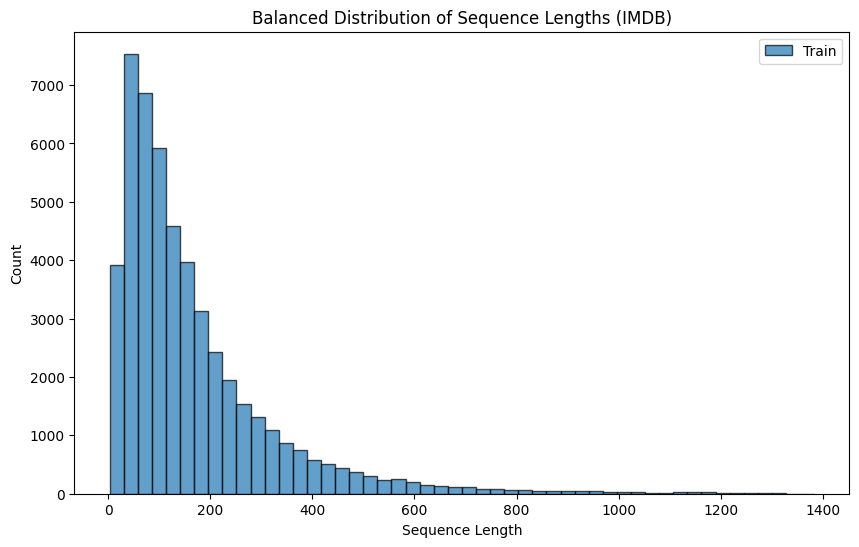

In [3]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)
encodings = tokenizer(s_train, add_special_tokens=True, padding=False, truncation=False)
lengths = [len(seq) for seq in encodings["input_ids"]]
plt.figure(figsize=(10,6))
plt.hist(lengths, bins=50, edgecolor='black', alpha=0.7, label='Train')
plt.title('Balanced Distribution of Sequence Lengths (IMDB)')
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.legend()
plt.show()


Truncations

Train size: 50000, Validation size: 10000, Test size: 10000


Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors


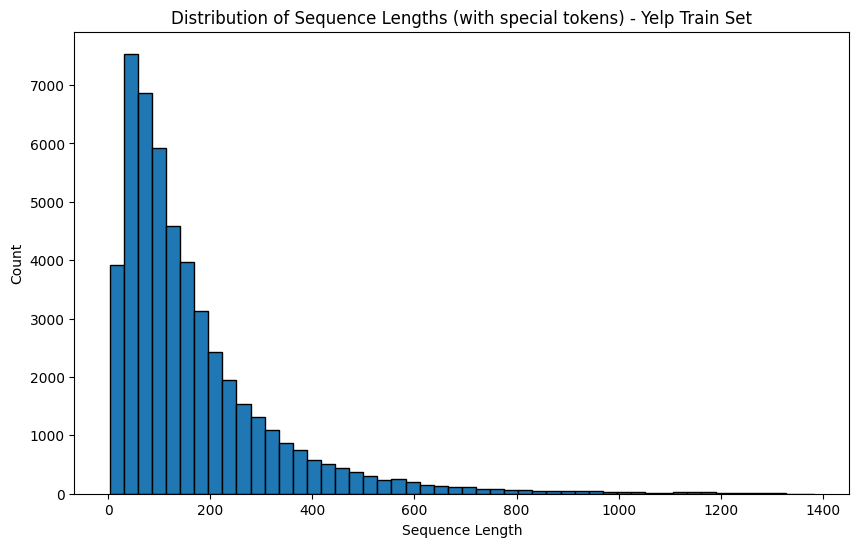

Most common sequence length: 52 (appeared 325 times)
Selected filtering window: [9, 95] tokens (delta = 43), fraction: 40.32%
Filtered and augmented train samples: 20443
Filtered and augmented validation samples: 4000
Filtered and augmented test samples: 4000

Train sample count: 20443
Label 1: 10969 (53.66%)
Label 0: 9474 (46.34%)

Validation sample count: 4000
Label 0: 1779 (44.47%)
Label 1: 2221 (55.53%)

Test sample count: 4000
Label 0: 1779 (44.47%)
Label 1: 2221 (55.53%)

Sample 1:
Original label: 1
Truncation level: 0.2
Augmented sentence: notch doctor in a top notch practice. can ' t say i am

Sample 2:
Original label: 1
Truncation level: 0.6
Augmented sentence: doctor who has correctly diagnosed every issue that my wife and i have had. unlike many of my past doctors, dr. goldberg is very accessible and we have been able to schedule appointments with him and his staff very quickly.

Sample 3:
Original label: 1
Truncation level: 0.4
Augmented sentence: t miss stop for the

Sampl

In [4]:
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import torch
from datasets import load_dataset
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast
from collections import Counter
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
dataset = load_dataset("yelp_review_full")
def filter_reviews(example):
    return example['label'] in [0, 4]
train_dataset = dataset['train'].filter(filter_reviews)
test_dataset  = dataset['test'].filter(filter_reviews)
label_map = {0: 0, 4: 1}
train_dataset = train_dataset.map(lambda x: {'label': label_map[x['label']]})
test_dataset  = test_dataset.map(lambda x: {'label': label_map[x['label']]})
s_train = train_dataset['text']
y_train = train_dataset['label']
s_test  = test_dataset['text']
y_test  = test_dataset['label']
train_sample_size = 50000
test_sample_size  = 10000
s_train, y_train = s_train[:train_sample_size], y_train[:train_sample_size]
s_test, y_test   = s_test[:test_sample_size], y_test[:test_sample_size]
val_ratio = 1
val_size = int(len(s_test) * val_ratio)
s_val, y_val = s_test[:val_size], y_test[:val_size]
print(f"Train size: {len(s_train)}, Validation size: {len(s_val)}, Test size: {len(s_test)}")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
encodings_train = tokenizer(s_train, add_special_tokens=True, padding=False, truncation=False)
train_lengths = [len(seq) for seq in encodings_train["input_ids"]]
plt.figure(figsize=(10,6))
plt.hist(train_lengths, bins=50, edgecolor='black')
plt.title("Distribution of Sequence Lengths (with special tokens) - Yelp Train Set")
plt.xlabel("Sequence Length")
plt.ylabel("Count")
plt.show()
length_counter = Counter(train_lengths)
most_common_length, count_common = length_counter.most_common(1)[0]
print(f"Most common sequence length: {most_common_length} (appeared {count_common} times)")
desired_fraction = 0.4
delta = 0
total_samples = len(train_lengths)
while True:
    lower_bound_candidate = most_common_length - delta
    upper_bound_candidate = most_common_length + delta
    count_in_window = sum(1 for l in train_lengths if lower_bound_candidate <= l <= upper_bound_candidate)
    fraction = count_in_window / total_samples
    if fraction >= desired_fraction:
        break
    delta += 1
target_lower = most_common_length - delta
target_upper = most_common_length + delta
print(f"Selected filtering window: [{target_lower}, {target_upper}] tokens (delta = {delta}), fraction: {fraction:.2%}")
trunc_levels = [0.2, 0.4, 0.6, 0.8,1]
def augment_sentence(sentence, tokenizer, levels):
    tokens = tokenizer.tokenize(sentence)
    L = len(tokens)
    if L == 0:
        return sentence, None
    level = random.choice(levels)
    window_length = max(1, int(round(level * L)))
    if window_length >= L:
        return sentence, level
    start_idx = random.randint(0, L - window_length)
    truncated_tokens = tokens[start_idx:start_idx + window_length]
    augmented_sentence = tokenizer.convert_tokens_to_string(truncated_tokens)
    return augmented_sentence, level
def filter_and_augment(sentences, labels, tokenizer, lower_bound, upper_bound, levels):
    augmented_sentences = []
    augmented_labels = []
    truncation_levels_record = []
    for sent, lbl in zip(sentences, labels):
        tokens = tokenizer.tokenize(sent)
        L = len(tokens)
        if lower_bound <= L <= upper_bound:
            aug_sent, level = augment_sentence(sent, tokenizer, levels)
            augmented_sentences.append(aug_sent)
            augmented_labels.append(lbl)
            truncation_levels_record.append(level)
    return augmented_sentences, augmented_labels, truncation_levels_record
s_train_aug, y_train_aug, train_trunc_levels = filter_and_augment(
    s_train, y_train, tokenizer, target_lower, target_upper, trunc_levels)
s_val_aug, y_val_aug, val_trunc_levels = filter_and_augment(
    s_val, y_val, tokenizer, target_lower, target_upper, trunc_levels)
s_test_aug, y_test_aug, test_trunc_levels = filter_and_augment(
    s_test, y_test, tokenizer, target_lower, target_upper, trunc_levels)
print("Filtered and augmented train samples:", len(s_train_aug))
print("Filtered and augmented validation samples:", len(s_val_aug))
print("Filtered and augmented test samples:", len(s_test_aug))
def print_label_ratio(labels, dataset_name):
    counter = Counter(labels)
    total = sum(counter.values())
    print(f"\n{dataset_name} sample count: {total}")
    for label, count in counter.items():
        print(f"Label {label}: {count} ({count/total:.2%})")
print_label_ratio(y_train_aug, "Train")
print_label_ratio(y_val_aug, "Validation")
print_label_ratio(y_test_aug, "Test")
for i in range(min(5, len(s_train_aug))):
    print(f"\nSample {i+1}:")
    print("Original label:", y_train_aug[i])
    print("Truncation level:", train_trunc_levels[i])
    print("Augmented sentence:", s_train_aug[i])


In [5]:
for i in range(min(5, len(s_val_aug))):
    print(f"\nSample {i+1}:")
    print("Original label:", y_val_aug[i])
    print("Truncation level:", val_trunc_levels[i])
    print("Augmented sentence:", s_val_aug[i])



Sample 1:
Original label: 0
Truncation level: 0.6
Augmented sentence: to give us estimates for a deck ( one of them the owner ). both times, we never heard from them. not a call, not the

Sample 2:
Original label: 0
Truncation level: 0.2
Augmented sentence: the food is so - so. \ nif you want good

Sample 3:
Original label: 1
Truncation level: 0.4
Augmented sentence: panera location in the pittsburgh area. friendly, plenty of room to sit, and good quality food & coffee. panera

Sample 4:
Original label: 1
Truncation level: 0.8
Augmented sentence: this place is amazing!!! jim is a great artist!!! traveled all the way from tampa just to get my tattoo!!! i would

Sample 5:
Original label: 1
Truncation level: 0.4
Augmented sentence: always go out of my way to get coffee from here when i ' m in


Balance

In [3]:
truncations = [80,160,240,320,400]
def process_and_balance_dataset(sentences, labels, truncations, seed=42):
    random.seed(seed)
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)
    encodings = tokenizer(sentences, add_special_tokens=True, padding=False, truncation=False)
    lengths = [len(seq) for seq in encodings["input_ids"]]
    bins = [0] + truncations
    bin_indices = {i: [] for i in range(len(bins) - 1)}
    for i, seq_len in enumerate(lengths):
        for b in range(len(bins) - 1):
            if bins[b] <= seq_len < bins[b+1]:
                bin_indices[b].append(i)
                break
    non_empty_bins = [idxs for idxs in bin_indices.values() if len(idxs) > 0]
    if not non_empty_bins:
        return sentences, labels
    min_count = min(len(idxs) for idxs in non_empty_bins)
    sampled_indices = []
    for b, idxs in bin_indices.items():
        if len(idxs) >= min_count:
            sampled_indices.extend(random.sample(idxs, min_count))
        else:
            sampled_indices.extend(idxs)
    balanced_sentences = [sentences[i] for i in sampled_indices]
    balanced_labels = [labels[i] for i in sampled_indices]
    return balanced_sentences, balanced_labels,lengths
balanced_s_train, balanced_y_train ,lengths_t= process_and_balance_dataset(s_train, y_train, truncations)
balanced_s_val, balanced_y_val ,lengths_v= process_and_balance_dataset(s_val, y_val, truncations)


Token indices sequence length is longer than the specified maximum sequence length for this model (1019 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


In [6]:
len(balanced_y_val)


NameError: name 'balanced_y_val' is not defined

In [8]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0.0, save_path=None):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.save_path = save_path
    def __call__(self, val_loss, model=None):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            if self.save_path and model is not None:
                torch.save(model.state_dict(), self.save_path)
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
def pool_embeddings(embeddings, attention_mask, strategy="cls"):
    if strategy == "cls":
        return embeddings[:, 0, :]
    elif strategy == "mean_without_padding":
        mask = attention_mask.unsqueeze(-1).float()
        sum_embeddings = (embeddings * mask).sum(dim=1)
        valid_count = mask.sum(dim=1)
        return sum_embeddings / (valid_count + 1e-8)
    else:
        raise ValueError("Unsupported pooling strategy.")
def evaluate_model(base_model, classifier, dataloader, device, criterion, pooling):
    base_model.eval()
    classifier.eval()
    total_loss = 0.0
    total_count = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = base_model(input_ids, attention_mask=attention_mask)
            last_hidden = outputs.last_hidden_state
            pooled = pool_embeddings(last_hidden, attention_mask, strategy=pooling)
            logits = classifier(pooled)
            loss = criterion(logits, labels)
            batch_size = input_ids.size(0)
            total_loss += loss.item() * batch_size
            total_count += batch_size
    return total_loss / total_count
def train_ensemble(
    s_train,
    y_train,
    s_val,
    y_val,
    pooling="cls",
    n_trainings=3,
    epochs=10,
    batch_size=32,
    max_length=128,
    lr=1e-4,
    patience=3,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)
    train_encodings = tokenizer(list(s_train), padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    val_encodings = tokenizer(list(s_val), padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], y_train_tensor)
    val_dataset = TensorDataset(val_encodings["input_ids"], val_encodings["attention_mask"], y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    predictions_df = pd.DataFrame()
    for i in tqdm(range(n_trainings), desc="Ensemble training"):
        base_model = BertModel.from_pretrained("bert-base-uncased").to(device)
        for param in base_model.parameters():
            param.requires_grad = False
        classifier = nn.Linear(base_model.config.hidden_size, 2).to(device)
        optimizer = torch.optim.Adam(classifier.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()
        early_stopper = EarlyStopping(patience=patience, min_delta=0.001, save_path=f"model_best_{i}.pth")
        for epoch in range(epochs):
            base_model.train()
            classifier.train()
            total_train_loss = 0.0
            total_train_count = 0
            for batch in train_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                optimizer.zero_grad()
                outputs = base_model(input_ids, attention_mask=attention_mask)
                last_hidden = outputs.last_hidden_state
                pooled = pool_embeddings(last_hidden, attention_mask, strategy=pooling)
                logits = classifier(pooled)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
                batch_size_ = input_ids.size(0)
                total_train_loss += loss.item() * batch_size_
                total_train_count += batch_size_
            avg_train_loss = total_train_loss / total_train_count
            val_loss = evaluate_model(base_model, classifier, val_loader, device, criterion, pooling)
            print(f"Model {i+1}, Epoch {epoch+1}/{epochs}, "
                  f"Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")
            early_stopper(val_loss, model=classifier)
            if early_stopper.early_stop:
                print(f"Early stopping triggered for model {i+1}. Loading best model weights.")
                classifier.load_state_dict(torch.load(f"model_best_{i}.pth"))
                break
        base_model.eval()
        classifier.eval()
        preds_list = []
        with torch.no_grad():
            for batch in val_loader:
                input_ids, attention_mask, labels = [b.to(device) for b in batch]
                outputs = base_model(input_ids, attention_mask=attention_mask)
                last_hidden = outputs.last_hidden_state
                pooled = pool_embeddings(last_hidden, attention_mask, strategy=pooling)
                logits = classifier(pooled)
                probs = F.softmax(logits, dim=1)
                preds_list.append(probs[:, 1].cpu().numpy())
        preds_column = np.concatenate(preds_list, axis=0)
        predictions_df[i] = preds_column
    print(f"Shape of predictions_df: {predictions_df.shape}")
    print(f"Sample predictions:\n{predictions_df.head()}")
    if not predictions_df.empty:
        model_dir = f'model'
        os.makedirs(model_dir, exist_ok=True)
        predictions_path = os.path.join(model_dir, f'ntrain_{pooling}_sq{max_length}_yelp_bal.pkl')
        with open(predictions_path, 'wb') as f:
            pickle.dump(predictions_df, f)
        print(f"Predictions saved to {predictions_path}")
    else:
        print("Warning: predictions_df is empty. File not saved.")
    return predictions_df


truncation

In [9]:
truncation = [target_upper]
pooling_strategies = [ "cls",'mean_without_padding']
for max_l in truncation:
    for pool in pooling_strategies:
        print(f"\n=== Running ensemble training with max_length={max_l}, pooling={pool} ===")
        ensemble_predictions = train_ensemble(
            s_train=s_train_aug,
                                            y_train=y_train_aug,
                                            s_val=s_val_aug,
                                            y_val=y_val_aug,
                                            pooling=pool,
                                            n_trainings=10,
                                            epochs=10,
                                            batch_size=2048,
                                            max_length=max_l,
                                            lr=1e-3,
                                            patience=3,
                                            device="cuda"
                                            )



=== Running ensemble training with max_length=95, pooling=cls ===
Using device: cuda


Ensemble training:   0%|          | 0/10 [00:00<?, ?it/s]

Model 1, Epoch 1/10, Train Loss: 0.6483, Val Loss: 0.5733
Model 1, Epoch 2/10, Train Loss: 0.5473, Val Loss: 0.4900
Model 1, Epoch 3/10, Train Loss: 0.4797, Val Loss: 0.4367
Model 1, Epoch 4/10, Train Loss: 0.4364, Val Loss: 0.4022
Model 1, Epoch 5/10, Train Loss: 0.4057, Val Loss: 0.3794
Model 1, Epoch 6/10, Train Loss: 0.3880, Val Loss: 0.3636
Model 1, Epoch 7/10, Train Loss: 0.3734, Val Loss: 0.3526
Model 1, Epoch 8/10, Train Loss: 0.3608, Val Loss: 0.3432
Model 1, Epoch 9/10, Train Loss: 0.3538, Val Loss: 0.3367
Model 1, Epoch 10/10, Train Loss: 0.3498, Val Loss: 0.3314


Ensemble training:  10%|█         | 1/10 [09:31<1:25:47, 571.94s/it]

Model 2, Epoch 1/10, Train Loss: 0.6451, Val Loss: 0.5735
Model 2, Epoch 2/10, Train Loss: 0.5462, Val Loss: 0.4910
Model 2, Epoch 3/10, Train Loss: 0.4803, Val Loss: 0.4392
Model 2, Epoch 4/10, Train Loss: 0.4374, Val Loss: 0.4055
Model 2, Epoch 5/10, Train Loss: 0.4100, Val Loss: 0.3832
Model 2, Epoch 6/10, Train Loss: 0.3882, Val Loss: 0.3667
Model 2, Epoch 7/10, Train Loss: 0.3739, Val Loss: 0.3546
Model 2, Epoch 8/10, Train Loss: 0.3615, Val Loss: 0.3455
Model 2, Epoch 9/10, Train Loss: 0.3545, Val Loss: 0.3387
Model 2, Epoch 10/10, Train Loss: 0.3470, Val Loss: 0.3335


Ensemble training:  20%|██        | 2/10 [19:02<1:16:11, 571.40s/it]

Model 3, Epoch 1/10, Train Loss: 0.6789, Val Loss: 0.6032
Model 3, Epoch 2/10, Train Loss: 0.5816, Val Loss: 0.5264
Model 3, Epoch 3/10, Train Loss: 0.5146, Val Loss: 0.4717
Model 3, Epoch 4/10, Train Loss: 0.4693, Val Loss: 0.4336
Model 3, Epoch 5/10, Train Loss: 0.4358, Val Loss: 0.4064
Model 3, Epoch 6/10, Train Loss: 0.4118, Val Loss: 0.3867
Model 3, Epoch 7/10, Train Loss: 0.3946, Val Loss: 0.3718
Model 3, Epoch 8/10, Train Loss: 0.3805, Val Loss: 0.3604
Model 3, Epoch 9/10, Train Loss: 0.3705, Val Loss: 0.3515
Model 3, Epoch 10/10, Train Loss: 0.3619, Val Loss: 0.3443


Ensemble training:  30%|███       | 3/10 [28:32<1:06:35, 570.76s/it]

Model 4, Epoch 1/10, Train Loss: 0.6481, Val Loss: 0.5775
Model 4, Epoch 2/10, Train Loss: 0.5492, Val Loss: 0.4929
Model 4, Epoch 3/10, Train Loss: 0.4814, Val Loss: 0.4406
Model 4, Epoch 4/10, Train Loss: 0.4403, Val Loss: 0.4057
Model 4, Epoch 5/10, Train Loss: 0.4099, Val Loss: 0.3823
Model 4, Epoch 6/10, Train Loss: 0.3878, Val Loss: 0.3660
Model 4, Epoch 7/10, Train Loss: 0.3723, Val Loss: 0.3537
Model 4, Epoch 8/10, Train Loss: 0.3640, Val Loss: 0.3449
Model 4, Epoch 9/10, Train Loss: 0.3552, Val Loss: 0.3380
Model 4, Epoch 10/10, Train Loss: 0.3480, Val Loss: 0.3324


Ensemble training:  40%|████      | 4/10 [38:03<57:04, 570.83s/it]  

Model 5, Epoch 1/10, Train Loss: 0.6576, Val Loss: 0.5849
Model 5, Epoch 2/10, Train Loss: 0.5636, Val Loss: 0.5097
Model 5, Epoch 3/10, Train Loss: 0.5003, Val Loss: 0.4576
Model 5, Epoch 4/10, Train Loss: 0.4557, Val Loss: 0.4216
Model 5, Epoch 5/10, Train Loss: 0.4253, Val Loss: 0.3957
Model 5, Epoch 6/10, Train Loss: 0.4015, Val Loss: 0.3777
Model 5, Epoch 7/10, Train Loss: 0.3865, Val Loss: 0.3645
Model 5, Epoch 8/10, Train Loss: 0.3730, Val Loss: 0.3541
Model 5, Epoch 9/10, Train Loss: 0.3640, Val Loss: 0.3459
Model 5, Epoch 10/10, Train Loss: 0.3544, Val Loss: 0.3395


Ensemble training:  50%|█████     | 5/10 [47:35<47:35, 571.05s/it]

Model 6, Epoch 1/10, Train Loss: 0.6320, Val Loss: 0.5618
Model 6, Epoch 2/10, Train Loss: 0.5345, Val Loss: 0.4810
Model 6, Epoch 3/10, Train Loss: 0.4694, Val Loss: 0.4298
Model 6, Epoch 4/10, Train Loss: 0.4279, Val Loss: 0.3968
Model 6, Epoch 5/10, Train Loss: 0.3988, Val Loss: 0.3749
Model 6, Epoch 6/10, Train Loss: 0.3824, Val Loss: 0.3597
Model 6, Epoch 7/10, Train Loss: 0.3676, Val Loss: 0.3489
Model 6, Epoch 8/10, Train Loss: 0.3550, Val Loss: 0.3412
Model 6, Epoch 9/10, Train Loss: 0.3508, Val Loss: 0.3343
Model 6, Epoch 10/10, Train Loss: 0.3433, Val Loss: 0.3294


Ensemble training:  60%|██████    | 6/10 [57:06<38:04, 571.13s/it]

Model 7, Epoch 1/10, Train Loss: 0.6445, Val Loss: 0.5645
Model 7, Epoch 2/10, Train Loss: 0.5406, Val Loss: 0.4814
Model 7, Epoch 3/10, Train Loss: 0.4725, Val Loss: 0.4312
Model 7, Epoch 4/10, Train Loss: 0.4310, Val Loss: 0.3968
Model 7, Epoch 5/10, Train Loss: 0.4039, Val Loss: 0.3748
Model 7, Epoch 6/10, Train Loss: 0.3846, Val Loss: 0.3597
Model 7, Epoch 7/10, Train Loss: 0.3695, Val Loss: 0.3487
Model 7, Epoch 8/10, Train Loss: 0.3596, Val Loss: 0.3405
Model 7, Epoch 9/10, Train Loss: 0.3511, Val Loss: 0.3345
Model 7, Epoch 10/10, Train Loss: 0.3451, Val Loss: 0.3291


Ensemble training:  70%|███████   | 7/10 [1:06:38<28:34, 571.49s/it]

Model 8, Epoch 1/10, Train Loss: 0.6617, Val Loss: 0.5895
Model 8, Epoch 2/10, Train Loss: 0.5561, Val Loss: 0.4994
Model 8, Epoch 3/10, Train Loss: 0.4849, Val Loss: 0.4439
Model 8, Epoch 4/10, Train Loss: 0.4400, Val Loss: 0.4083
Model 8, Epoch 5/10, Train Loss: 0.4112, Val Loss: 0.3843
Model 8, Epoch 6/10, Train Loss: 0.3908, Val Loss: 0.3675
Model 8, Epoch 7/10, Train Loss: 0.3746, Val Loss: 0.3551
Model 8, Epoch 8/10, Train Loss: 0.3634, Val Loss: 0.3464
Model 8, Epoch 9/10, Train Loss: 0.3570, Val Loss: 0.3392
Model 8, Epoch 10/10, Train Loss: 0.3498, Val Loss: 0.3340


Ensemble training:  80%|████████  | 8/10 [1:16:10<19:03, 571.65s/it]

Model 9, Epoch 1/10, Train Loss: 0.6451, Val Loss: 0.5733
Model 9, Epoch 2/10, Train Loss: 0.5434, Val Loss: 0.4881
Model 9, Epoch 3/10, Train Loss: 0.4756, Val Loss: 0.4365
Model 9, Epoch 4/10, Train Loss: 0.4337, Val Loss: 0.4015
Model 9, Epoch 5/10, Train Loss: 0.4047, Val Loss: 0.3792
Model 9, Epoch 6/10, Train Loss: 0.3843, Val Loss: 0.3633
Model 9, Epoch 7/10, Train Loss: 0.3695, Val Loss: 0.3521
Model 9, Epoch 8/10, Train Loss: 0.3605, Val Loss: 0.3443
Model 9, Epoch 9/10, Train Loss: 0.3519, Val Loss: 0.3368
Model 9, Epoch 10/10, Train Loss: 0.3472, Val Loss: 0.3315


Ensemble training:  90%|█████████ | 9/10 [1:25:41<09:31, 571.47s/it]

Model 10, Epoch 1/10, Train Loss: 0.6694, Val Loss: 0.5912
Model 10, Epoch 2/10, Train Loss: 0.5714, Val Loss: 0.5142
Model 10, Epoch 3/10, Train Loss: 0.5047, Val Loss: 0.4606
Model 10, Epoch 4/10, Train Loss: 0.4603, Val Loss: 0.4238
Model 10, Epoch 5/10, Train Loss: 0.4272, Val Loss: 0.3978
Model 10, Epoch 6/10, Train Loss: 0.4061, Val Loss: 0.3793
Model 10, Epoch 7/10, Train Loss: 0.3893, Val Loss: 0.3657
Model 10, Epoch 8/10, Train Loss: 0.3755, Val Loss: 0.3552
Model 10, Epoch 9/10, Train Loss: 0.3657, Val Loss: 0.3470
Model 10, Epoch 10/10, Train Loss: 0.3561, Val Loss: 0.3406


Ensemble training: 100%|██████████| 10/10 [1:35:14<00:00, 571.43s/it]


Shape of predictions_df: (4000, 10)
Sample predictions:
          0         1         2         3         4         5         6  \
0  0.048330  0.047635  0.053940  0.038547  0.052463  0.041034  0.034487   
1  0.553478  0.574142  0.571629  0.549201  0.548619  0.526294  0.582229   
2  0.981102  0.977278  0.972820  0.975611  0.970186  0.972940  0.982358   
3  0.960270  0.959943  0.943301  0.952193  0.937484  0.958280  0.964606   
4  0.787840  0.792874  0.754013  0.767877  0.769480  0.750201  0.801434   

          7         8         9  
0  0.047072  0.038924  0.067101  
1  0.549893  0.566191  0.528642  
2  0.978212  0.981914  0.966745  
3  0.958835  0.958299  0.945564  
4  0.794253  0.808779  0.781314  
Predictions saved to model/ntrain_cls_sq95_yelp_bal.pkl

=== Running ensemble training with max_length=95, pooling=mean_without_padding ===
Using device: cuda


Ensemble training:   0%|          | 0/10 [00:00<?, ?it/s]

Model 1, Epoch 1/10, Train Loss: 0.6263, Val Loss: 0.5577
Model 1, Epoch 2/10, Train Loss: 0.5258, Val Loss: 0.4794
Model 1, Epoch 3/10, Train Loss: 0.4599, Val Loss: 0.4270
Model 1, Epoch 4/10, Train Loss: 0.4164, Val Loss: 0.3914
Model 1, Epoch 5/10, Train Loss: 0.3851, Val Loss: 0.3670
Model 1, Epoch 6/10, Train Loss: 0.3644, Val Loss: 0.3499
Model 1, Epoch 7/10, Train Loss: 0.3498, Val Loss: 0.3365
Model 1, Epoch 8/10, Train Loss: 0.3370, Val Loss: 0.3269
Model 1, Epoch 9/10, Train Loss: 0.3271, Val Loss: 0.3191
Model 1, Epoch 10/10, Train Loss: 0.3199, Val Loss: 0.3124


Ensemble training:  10%|█         | 1/10 [09:33<1:25:57, 573.05s/it]

Model 2, Epoch 1/10, Train Loss: 0.6397, Val Loss: 0.5679
Model 2, Epoch 2/10, Train Loss: 0.5350, Val Loss: 0.4847
Model 2, Epoch 3/10, Train Loss: 0.4656, Val Loss: 0.4301
Model 2, Epoch 4/10, Train Loss: 0.4194, Val Loss: 0.3947
Model 2, Epoch 5/10, Train Loss: 0.3886, Val Loss: 0.3692
Model 2, Epoch 6/10, Train Loss: 0.3666, Val Loss: 0.3510
Model 2, Epoch 7/10, Train Loss: 0.3509, Val Loss: 0.3386
Model 2, Epoch 8/10, Train Loss: 0.3379, Val Loss: 0.3276
Model 2, Epoch 9/10, Train Loss: 0.3286, Val Loss: 0.3198
Model 2, Epoch 10/10, Train Loss: 0.3205, Val Loss: 0.3133


Ensemble training:  20%|██        | 2/10 [19:06<1:16:24, 573.09s/it]

Model 3, Epoch 1/10, Train Loss: 0.6475, Val Loss: 0.5788
Model 3, Epoch 2/10, Train Loss: 0.5446, Val Loss: 0.4957
Model 3, Epoch 3/10, Train Loss: 0.4736, Val Loss: 0.4397
Model 3, Epoch 4/10, Train Loss: 0.4269, Val Loss: 0.4018
Model 3, Epoch 5/10, Train Loss: 0.3945, Val Loss: 0.3754
Model 3, Epoch 6/10, Train Loss: 0.3701, Val Loss: 0.3562
Model 3, Epoch 7/10, Train Loss: 0.3531, Val Loss: 0.3423
Model 3, Epoch 8/10, Train Loss: 0.3419, Val Loss: 0.3315
Model 3, Epoch 9/10, Train Loss: 0.3305, Val Loss: 0.3233
Model 3, Epoch 10/10, Train Loss: 0.3240, Val Loss: 0.3165


Ensemble training:  30%|███       | 3/10 [28:36<1:06:42, 571.81s/it]

Model 4, Epoch 1/10, Train Loss: 0.6439, Val Loss: 0.5774
Model 4, Epoch 2/10, Train Loss: 0.5439, Val Loss: 0.4960
Model 4, Epoch 3/10, Train Loss: 0.4754, Val Loss: 0.4406
Model 4, Epoch 4/10, Train Loss: 0.4286, Val Loss: 0.4029
Model 4, Epoch 5/10, Train Loss: 0.3955, Val Loss: 0.3762
Model 4, Epoch 6/10, Train Loss: 0.3721, Val Loss: 0.3569
Model 4, Epoch 7/10, Train Loss: 0.3549, Val Loss: 0.3424
Model 4, Epoch 8/10, Train Loss: 0.3415, Val Loss: 0.3315
Model 4, Epoch 9/10, Train Loss: 0.3315, Val Loss: 0.3230
Model 4, Epoch 10/10, Train Loss: 0.3232, Val Loss: 0.3168


Ensemble training:  40%|████      | 4/10 [38:09<57:13, 572.25s/it]  

Model 5, Epoch 1/10, Train Loss: 0.6753, Val Loss: 0.6065
Model 5, Epoch 2/10, Train Loss: 0.5766, Val Loss: 0.5268
Model 5, Epoch 3/10, Train Loss: 0.5056, Val Loss: 0.4682
Model 5, Epoch 4/10, Train Loss: 0.4547, Val Loss: 0.4269
Model 5, Epoch 5/10, Train Loss: 0.4193, Val Loss: 0.3970
Model 5, Epoch 6/10, Train Loss: 0.3921, Val Loss: 0.3751
Model 5, Epoch 7/10, Train Loss: 0.3726, Val Loss: 0.3582
Model 5, Epoch 8/10, Train Loss: 0.3581, Val Loss: 0.3455
Model 5, Epoch 9/10, Train Loss: 0.3457, Val Loss: 0.3351
Model 5, Epoch 10/10, Train Loss: 0.3350, Val Loss: 0.3268


Ensemble training:  50%|█████     | 5/10 [47:41<47:40, 572.18s/it]

Model 6, Epoch 1/10, Train Loss: 0.6278, Val Loss: 0.5651
Model 6, Epoch 2/10, Train Loss: 0.5329, Val Loss: 0.4887
Model 6, Epoch 3/10, Train Loss: 0.4672, Val Loss: 0.4354
Model 6, Epoch 4/10, Train Loss: 0.4230, Val Loss: 0.3990
Model 6, Epoch 5/10, Train Loss: 0.3908, Val Loss: 0.3735
Model 6, Epoch 6/10, Train Loss: 0.3678, Val Loss: 0.3553
Model 6, Epoch 7/10, Train Loss: 0.3518, Val Loss: 0.3410
Model 6, Epoch 8/10, Train Loss: 0.3399, Val Loss: 0.3305
Model 6, Epoch 9/10, Train Loss: 0.3308, Val Loss: 0.3222
Model 6, Epoch 10/10, Train Loss: 0.3232, Val Loss: 0.3152


Ensemble training:  60%|██████    | 6/10 [57:13<38:09, 572.29s/it]

Model 7, Epoch 1/10, Train Loss: 0.6368, Val Loss: 0.5720
Model 7, Epoch 2/10, Train Loss: 0.5370, Val Loss: 0.4908
Model 7, Epoch 3/10, Train Loss: 0.4692, Val Loss: 0.4356
Model 7, Epoch 4/10, Train Loss: 0.4230, Val Loss: 0.3981
Model 7, Epoch 5/10, Train Loss: 0.3906, Val Loss: 0.3720
Model 7, Epoch 6/10, Train Loss: 0.3683, Val Loss: 0.3538
Model 7, Epoch 7/10, Train Loss: 0.3518, Val Loss: 0.3398
Model 7, Epoch 8/10, Train Loss: 0.3397, Val Loss: 0.3290
Model 7, Epoch 9/10, Train Loss: 0.3290, Val Loss: 0.3209
Model 7, Epoch 10/10, Train Loss: 0.3216, Val Loss: 0.3141


Ensemble training:  70%|███████   | 7/10 [1:06:46<28:37, 572.48s/it]

Model 8, Epoch 1/10, Train Loss: 0.6477, Val Loss: 0.5792
Model 8, Epoch 2/10, Train Loss: 0.5446, Val Loss: 0.4954
Model 8, Epoch 3/10, Train Loss: 0.4734, Val Loss: 0.4395
Model 8, Epoch 4/10, Train Loss: 0.4259, Val Loss: 0.4011
Model 8, Epoch 5/10, Train Loss: 0.3935, Val Loss: 0.3747
Model 8, Epoch 6/10, Train Loss: 0.3696, Val Loss: 0.3554
Model 8, Epoch 7/10, Train Loss: 0.3536, Val Loss: 0.3419
Model 8, Epoch 8/10, Train Loss: 0.3418, Val Loss: 0.3308
Model 8, Epoch 9/10, Train Loss: 0.3307, Val Loss: 0.3219
Model 8, Epoch 10/10, Train Loss: 0.3235, Val Loss: 0.3154


Ensemble training:  80%|████████  | 8/10 [1:16:19<19:05, 572.64s/it]

Model 9, Epoch 1/10, Train Loss: 0.6439, Val Loss: 0.5808
Model 9, Epoch 2/10, Train Loss: 0.5462, Val Loss: 0.5003
Model 9, Epoch 3/10, Train Loss: 0.4774, Val Loss: 0.4448
Model 9, Epoch 4/10, Train Loss: 0.4305, Val Loss: 0.4068
Model 9, Epoch 5/10, Train Loss: 0.3989, Val Loss: 0.3802
Model 9, Epoch 6/10, Train Loss: 0.3747, Val Loss: 0.3604
Model 9, Epoch 7/10, Train Loss: 0.3573, Val Loss: 0.3462
Model 9, Epoch 8/10, Train Loss: 0.3446, Val Loss: 0.3345
Model 9, Epoch 9/10, Train Loss: 0.3332, Val Loss: 0.3263
Model 9, Epoch 10/10, Train Loss: 0.3259, Val Loss: 0.3188


Ensemble training:  90%|█████████ | 9/10 [1:25:52<09:32, 572.59s/it]

Model 10, Epoch 1/10, Train Loss: 0.6459, Val Loss: 0.5751
Model 10, Epoch 2/10, Train Loss: 0.5390, Val Loss: 0.4895
Model 10, Epoch 3/10, Train Loss: 0.4683, Val Loss: 0.4339
Model 10, Epoch 4/10, Train Loss: 0.4212, Val Loss: 0.3967
Model 10, Epoch 5/10, Train Loss: 0.3898, Val Loss: 0.3709
Model 10, Epoch 6/10, Train Loss: 0.3665, Val Loss: 0.3519
Model 10, Epoch 7/10, Train Loss: 0.3508, Val Loss: 0.3383
Model 10, Epoch 8/10, Train Loss: 0.3368, Val Loss: 0.3282
Model 10, Epoch 9/10, Train Loss: 0.3270, Val Loss: 0.3196
Model 10, Epoch 10/10, Train Loss: 0.3213, Val Loss: 0.3131


Ensemble training: 100%|██████████| 10/10 [1:35:24<00:00, 572.48s/it]


Shape of predictions_df: (4000, 10)
Sample predictions:
          0         1         2         3         4         5         6  \
0  0.083677  0.093347  0.093038  0.110370  0.123756  0.106239  0.096058   
1  0.589845  0.604055  0.595343  0.647569  0.604638  0.603796  0.612853   
2  0.979409  0.977714  0.971647  0.980451  0.971883  0.982063  0.979101   
3  0.973567  0.971682  0.967938  0.975045  0.963567  0.976516  0.973638   
4  0.473874  0.408946  0.477323  0.534133  0.519400  0.483954  0.529229   

          7         8         9  
0  0.112778  0.111393  0.114574  
1  0.617914  0.634892  0.655197  
2  0.981703  0.979100  0.977026  
3  0.973315  0.974901  0.975668  
4  0.485983  0.539030  0.538328  
Predictions saved to model/ntrain_mean_without_padding_sq95_yelp_bal.pkl


balance

In [7]:
poolings = ["cls", "mean_without_padding"]
truncations = [
               "100"]
seq_l=target_upper
res_set = []
for pooling in poolings:
    try:
        with open(f'model/ntrain_{pooling}_sq{seq_l}_yelp_bal.pkl', 'rb') as f:
            sub_res = pickle.load(f)
    except FileNotFoundError:
        print(f"File model/ntrain_{pooling}_sq{seq_l}.pkl not found. Skipping.")
        continue
    res_set.append(sub_res)


In [8]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import (roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
                             brier_score_loss)
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns
def compute_ece(y_true, y_prob, n_bins=10):
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    bin_edges = np.linspace(0, 1, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower = bin_edges[i]
        bin_upper = bin_edges[i + 1]
        bin_mask = (y_prob > bin_lower) & (y_prob <= bin_upper)
        bin_count = np.sum(bin_mask)
        if bin_count > 0:
            bin_accuracy = np.mean(y_true[bin_mask] == 1)
            bin_confidence = np.mean(y_prob[bin_mask])
            ece += np.abs(bin_accuracy - bin_confidence) * (bin_count / len(y_true))
    return ece
def uncertainty_auroc(y, predictions, variance):
    y = np.array(y)
    predictions = np.array(predictions)
    variance = np.array(variance)
    correctness = (y == (predictions > 0.5))
    fprs, tprs, _ = roc_curve(correctness, -1 * variance)
    auc = roc_auc_score(correctness, -1 * variance)
    return tprs, fprs, auc
def calculate_ause(uncertainty, predictions, targets, metric='brier',
                   uncertainty_type='variance', bins=10, save_path=None, min_fraction=0.0,
                   max_fraction=0.9, ax=None, color='b', label='Sparsification Error'):
    if not (len(predictions) == len(targets) == len(uncertainty)):
        raise ValueError("predictions, targets, and uncertainty must have the same length.")
    if len(predictions) < 10:
        raise ValueError("Not enough predictions for sparsification.")
    def brier_score(preds, tgts):
        return np.mean((preds - tgts)**2)
    def mean_absolute_error(preds, tgts):
        return np.mean(np.abs(preds - tgts))
    def calculate_ece_metric(preds, tgts, n_bins=10):
        n = len(preds)
        if n == 0:
            return np.nan
        bin_edges = np.linspace(0., 1., n_bins + 1)
        bin_indices = np.digitize(preds, bin_edges, right=True) - 1
        ece = 0.0
        for i in range(n_bins):
            bin_mask = bin_indices == i
            bin_size = np.sum(bin_mask)
            if bin_size > 0:
                bin_confidence = np.mean(preds[bin_mask])
                bin_accuracy = np.mean(tgts[bin_mask])
                ece += (bin_size / n) * np.abs(bin_accuracy - bin_confidence)
        return ece
    def calculate_auc_metric(preds, tgts):
        if len(np.unique(tgts)) < 2:
            return np.nan
        return roc_auc_score(tgts, preds)
    if metric == 'brier':
        error_function = brier_score
    elif metric == 'mae':
        error_function = mean_absolute_error
    elif metric == 'ece':
        error_function = lambda p, t: calculate_ece_metric(p, t, n_bins=bins)
    elif metric == 'auc':
        error_function = calculate_auc_metric
    else:
        raise ValueError("Unknown metric. Choose from 'brier', 'mae', 'ece', or 'auc'.")
    sorted_inds_uncertainty = np.argsort(uncertainty)
    if metric in ['brier', 'mae']:
        if metric == 'brier':
            true_errors = (predictions - targets)**2
        else:
            true_errors = np.abs(predictions - targets)
        sorted_inds_error = np.argsort(true_errors)
    else:
        sorted_inds_error = None
    uncertainty_scores = []
    oracle_scores = []
    fractions = np.linspace(min_fraction, max_fraction, int((max_fraction - min_fraction)/0.01) + 1)
    num_samples = len(predictions)
    for fraction in fractions:
        num_keep = max(1, int((1.0 - fraction) * num_samples))
        inds_keep_uncertainty = sorted_inds_uncertainty[:num_keep]
        remaining_preds = predictions[inds_keep_uncertainty]
        remaining_targets = targets[inds_keep_uncertainty]
        try:
            uncertainty_error_score = error_function(remaining_preds, remaining_targets)
        except ValueError as e:
            print(f"Error calculating {metric} at fraction {fraction:.2f}: {e}")
            uncertainty_error_score = np.nan
        uncertainty_scores.append(uncertainty_error_score)
        if sorted_inds_error is not None:
            inds_keep_oracle = sorted_inds_error[:num_keep]
            oracle_preds = predictions[inds_keep_oracle]
            oracle_targets = targets[inds_keep_oracle]
            try:
                oracle_error_score = error_function(oracle_preds, oracle_targets)
            except ValueError as e:
                print(f"Error calculating Oracle {metric} at fraction {fraction:.2f}: {e}")
                oracle_error_score = np.nan
            oracle_scores.append(oracle_error_score)
        else:
            oracle_scores.append(np.nan)
    uncertainty_scores = np.array(uncertainty_scores)
    oracle_scores = np.array(oracle_scores)
    if metric in ['brier', 'mae']:
        uncertainty_scores_normalized = uncertainty_scores / uncertainty_scores[0]
        if sorted_inds_error is not None:
            oracle_scores_normalized = oracle_scores / oracle_scores[0]
        else:
            oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    elif metric == 'ece':
        uncertainty_scores_normalized = uncertainty_scores / uncertainty_scores[0]
        oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    elif metric == 'auc':
        uncertainty_scores_normalized = (1 - uncertainty_scores) / (1 - uncertainty_scores[0])
        oracle_scores_normalized = np.full_like(uncertainty_scores_normalized, np.nan)
    else:
        raise ValueError("Unknown metric.")
    ause_pred = np.trapz(y=uncertainty_scores_normalized, x=fractions) / (max_fraction - min_fraction)
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    if metric in ['brier', 'mae', 'ece', 'auc']:
        ax.plot(fractions, uncertainty_scores_normalized, label=f"{label} (AUSE={ause_pred:.4f})", color=color)
    ax.set_xlabel("Fraction of removed samples")
    ax.set_ylabel(f"{metric.upper()} Error (Normalized)")
    ax.set_ylim([0, 1.5])
    ax.set_title('Sparsification Curve')
    ax.legend()
    ax.grid(True)
    if save_path:
        plt.savefig(save_path)
    elif ax is None:
        plt.show()
    return ause_pred


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss
)
from sklearn.calibration import calibration_curve
from scipy.stats import norm
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
def compute_ece(y_true, y_prob, n_bins=10):
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=n_bins)
    ece = np.abs(prob_true - prob_pred).mean()
    return ece
def shannon_entropy(p, epsilon=1e-10):
    p = np.clip(p, epsilon, 1 - epsilon)
    entropy = -p * np.log(p) - (1 - p) * np.log(1 - p)
    return entropy
def model_result_show(prob_df_set, y, df_names, truncation_labels, truncation_colors, metric='brier'):
    y = np.array(y).ravel()
    num_poolings = len(prob_df_set)
    num_truncations = len(truncation_labels)
    fig, axes = plt.subplots(num_poolings, 9, figsize=(54, 6 * num_poolings))
    if num_poolings == 1:
        axes = np.array([axes])
    metrics_records = []
    colors = truncation_colors
    for i in range(num_poolings):
        pooling_name = df_names[i]
        ax_var_density = axes[i][0]
        ax_unc_roc = axes[i][1]
        ax_calibration = axes[i][2]
        ax_normal_roc = axes[i][3]
        ax_sparsification = axes[i][4]
        ax_brier_density = axes[i][5]
        ax_entropy_density = axes[i][6]
        ax_nll_density = axes[i][7]
        ax_pred_prob_density = axes[i][8]
        for t_idx in range(num_truncations):
            df = prob_df_set[i][t_idx]
            df = np.array(df)
            trunc_name = truncation_labels[t_idx]
            predictions = np.mean(df, axis=1)
            variance = np.var(df, axis=1)
            std_dev = np.sqrt(variance)
            normal_fpr, normal_tpr, _ = roc_curve(y, predictions)
            normal_auc = roc_auc_score(y, predictions)
            unc_tpr, unc_fpr, unc_auc = uncertainty_auroc(y, predictions, variance)
            prob_true, prob_pred = calibration_curve(y, predictions, n_bins=10)
            ece_score = compute_ece(y, predictions)
            auprc = average_precision_score(y, predictions)
            brier = (y - predictions) ** 2
            epsilon = 1e-10
            nll = - y * np.log(predictions + epsilon) - (1 - y) * np.log(1 - predictions + epsilon)
            entropy_pred = shannon_entropy(predictions)
            residuals = y - predictions
            residual_var = residuals ** 2
            pred_prob_mean = np.mean(predictions)
            c = colors[t_idx]
            variance_1 = np.round(np.mean(variance), 5)
            sns.kdeplot(
                variance,
                ax=ax_var_density,
                label=f"{trunc_name} (avg_Var={variance_1})",
                fill=False,
                color=c
            )
            ax_unc_roc.plot(
                unc_fpr,
                unc_tpr,
                label=f"{trunc_name} (AUROC={unc_auc:.2f})",
                color=c
            )
            ax_calibration.plot(
                prob_pred,
                prob_true,
                marker="o",
                label=f"{trunc_name} (ECE={ece_score:.2f})",
                color=c
            )
            ax_normal_roc.plot(
                normal_fpr,
                normal_tpr,
                label=f"{trunc_name} (AUC={normal_auc:.2f})",
                color=c
            )
            ause = calculate_ause(
                uncertainty=variance,
                predictions=predictions,
                targets=y,
                metric=metric,
                min_fraction=0.0,
                max_fraction=0.9,
                ax=ax_sparsification,
                color=c,
                label=f"{trunc_name}"
            )
            sns.kdeplot(
                brier,
                ax=ax_brier_density,
                label=f"{trunc_name} (Mean Brier={np.mean(brier):.4f})",
                color=c
            )
            sns.kdeplot(
                entropy_pred,
                ax=ax_entropy_density,
                label=f"{trunc_name} (Mean Entropy={np.mean(entropy_pred):.4f})",
                color=c
            )
            sns.kdeplot(
                nll,
                ax=ax_nll_density,
                label=f"{trunc_name} (Mean NLL={np.mean(nll):.4f})",
                color=c
            )
            sns.kdeplot(
                predictions,
                ax=ax_pred_prob_density,
                label=f"{trunc_name} (Mean Pred={pred_prob_mean:.4f})",
                color=c
            )
            metrics_records.append({
                "pooling": pooling_name,
                "truncation": trunc_name,
                "normal_auc": normal_auc,
                "uncertainty_auc": unc_auc,
                "auprc": auprc,
                "ece": ece_score,
                "brier_score_mean": np.mean(brier),
                "entropy_mean": np.mean(entropy_pred),
                "nll_mean": np.mean(nll),
                "pred_prob_mean": pred_prob_mean,
                "ause": ause,
                "var":np.mean(variance)
            })
        ax_var_density.set_title(f"{pooling_name} Variance Density")
        ax_var_density.set_xlabel("Variance")
        ax_var_density.set_xlim([-0.001, 0.01])
        ax_var_density.legend()
        ax_unc_roc.set_title(f"{pooling_name} Uncertainty ROC")
        ax_unc_roc.set_xlabel("False Positive Rate")
        ax_unc_roc.set_ylabel("True Positive Rate")
        ax_unc_roc.plot([0, 1], [0, 1], '--', color='gray')
        ax_unc_roc.legend()
        ax_unc_roc.grid(True)
        ax_calibration.set_title(f"{pooling_name} Calibration Curve")
        ax_calibration.set_xlabel("Mean Predicted Probability")
        ax_calibration.set_ylabel("Actual Positive Proportion")
        ax_calibration.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax_calibration.legend()
        ax_normal_roc.set_title(f"{pooling_name} ROC Curve")
        ax_normal_roc.set_xlabel("False Positive Rate")
        ax_normal_roc.set_ylabel("True Positive Rate")
        ax_normal_roc.plot([0, 1], [0, 1], '--', color="gray")
        ax_normal_roc.legend()
        ax_normal_roc.grid(True)
        ax_sparsification.set_title(f"{pooling_name} Sparsification Curve (Metric: {metric.upper()})")
        ax_sparsification.set_ylim([-0.01, 1.05])
        ax_sparsification.legend()
        ax_sparsification.grid(True)
        ax_brier_density.set_title(f"{pooling_name} Brier Score Density Plot")
        ax_brier_density.set_xlabel("Brier Score")
        ax_brier_density.set_ylabel("Density")
        ax_brier_density.legend()
        ax_entropy_density.set_title(f"{pooling_name} Prediction Distribution Entropy Density Plot")
        ax_entropy_density.set_xlabel("Entropy")
        ax_entropy_density.set_ylabel("Density")
        ax_entropy_density.legend()
        ax_nll_density.set_title(f"{pooling_name} Negative Log-Likelihood (NLL) Density Plot")
        ax_nll_density.set_xlabel("NLL")
        ax_nll_density.set_ylabel("Density")
        ax_nll_density.legend()
        ax_pred_prob_density.set_title(f"{pooling_name} Predicted Probability Density Plot")
        ax_pred_prob_density.set_xlabel("Predicted Probability")
        ax_pred_prob_density.set_ylabel("Density")
        ax_pred_prob_density.legend()
    plt.tight_layout()
    plt.show()
    return pd.DataFrame(metrics_records)


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve
)
def model_result_show(
    prob_df_set,
    y,
    n,
    df_names,
    truncations,
    truncation_colors,
    metric='brier'
):
    y = np.array(y).ravel()
    n = np.array(n).ravel()
    num_poolings = len(prob_df_set)
    fig, axes = plt.subplots(num_poolings, 10, figsize=(60, 6 * num_poolings))
    if num_poolings == 1:
        axes = np.array([axes])
    metrics_records = []
    for i in range(num_poolings):
        pooling_name = df_names[i]
        df_full = prob_df_set[i]
        df_full = np.array(df_full)
        ax_var_density        = axes[i][0]
        ax_unc_roc           = axes[i][1]
        ax_calibration       = axes[i][2]
        ax_normal_roc        = axes[i][3]
        ax_sparsification    = axes[i][4]
        ax_brier_density     = axes[i][5]
        ax_entropy_density   = axes[i][6]
        ax_nll_density       = axes[i][7]
        ax_pred_prob_density = axes[i][8]
        ax_pr                = axes[i][9]
        for t_idx, t_val in enumerate(truncations):
            if t_idx == 0:
                mask = (n <= t_val)
            else:
                mask = (n > truncations[t_idx - 1]) & (n <= t_val)
            if not np.any(mask):
                continue
            sub_df = df_full[mask]
            sub_y  = y[mask]
            fraction_data = sub_df.shape[0] / df_full.shape[0]
            predictions = np.mean(sub_df, axis=1)
            variance = np.var(sub_df, axis=1)
            std_dev = np.sqrt(variance)
            normal_fpr, normal_tpr, _ = roc_curve(sub_y, predictions)
            normal_auc = roc_auc_score(sub_y, predictions)
            unc_tpr, unc_fpr, unc_auc = uncertainty_auroc(sub_y, predictions, variance)
            prob_true, prob_pred = calibration_curve(sub_y, predictions, n_bins=10)
            ece_score = compute_ece(sub_y, predictions)
            precision, recall, thresholds = precision_recall_curve(sub_y, predictions)
            auprc = average_precision_score(sub_y, predictions)
            brier = (sub_y - predictions) ** 2
            epsilon = 1e-10
            nll = -sub_y * np.log(predictions + epsilon) - (1 - sub_y) * np.log(1 - predictions + epsilon)
            entropy_pred = shannon_entropy(predictions)
            ause = calculate_ause(
                uncertainty=variance,
                predictions=predictions,
                targets=sub_y,
                metric=metric,
                min_fraction=0.0,
                max_fraction=0.9,
                ax=ax_sparsification,
                color=truncation_colors[t_idx],
                label=f"{t_val}"
            )
            variance_mean  = np.mean(variance)
            brier_mean     = np.mean(brier)
            entropy_mean   = np.mean(entropy_pred)
            nll_mean       = np.mean(nll)
            pred_prob_mean = np.mean(predictions)
            if t_idx == 0:
                trunc_name = f"≤ {t_val}"
            else:
                trunc_name = f"{truncations[t_idx - 1]}-{t_val}"
            c = truncation_colors[t_idx]
            sns.kdeplot(
                variance,
                ax=ax_var_density,
                label=f"{trunc_name} (avgVar={variance_mean:.5f}, ratio={fraction_data:.2f})",
                fill=False,
                color=c
            )
            ax_unc_roc.plot(
                unc_fpr,
                unc_tpr,
                label=f"{trunc_name} (AUROC={unc_auc:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            ax_calibration.plot(
                prob_pred,
                prob_true,
                marker="o",
                label=f"{trunc_name} (ECE={ece_score:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            ax_normal_roc.plot(
                normal_fpr,
                normal_tpr,
                label=f"{trunc_name} (AUC={normal_auc:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                brier,
                ax=ax_brier_density,
                label=f"{trunc_name} (MeanBrier={brier_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                entropy_pred,
                ax=ax_entropy_density,
                label=f"{trunc_name} (MeanEntropy={entropy_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                nll,
                ax=ax_nll_density,
                label=f"{trunc_name} (MeanNLL={nll_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            sns.kdeplot(
                predictions,
                ax=ax_pred_prob_density,
                label=f"{trunc_name} (MeanPred={pred_prob_mean:.4f}, ratio={fraction_data:.2f})",
                color=c
            )
            ax_pr.plot(
                recall,
                precision,
                marker='.',
                label=f"{trunc_name} (AUPRC={auprc:.2f}, ratio={fraction_data:.2f})",
                color=c
            )
            metrics_records.append({
                "pooling": pooling_name,
                "truncation": trunc_name,
                "ratio": fraction_data,
                "normal_auc": normal_auc,
                "uncertainty_auc": unc_auc,
                "auprc": auprc,
                "ece": ece_score,
                "brier_score_mean": brier_mean,
                "entropy_mean": entropy_mean,
                "nll_mean": nll_mean,
                "pred_prob_mean": pred_prob_mean,
                "ause": ause,
                "var_mean": variance_mean
            })
        ax_var_density.set_title(f"{pooling_name} - Variance Density")
        ax_var_density.set_xlabel("Variance")
        ax_var_density.legend()
        ax_unc_roc.set_title(f"{pooling_name} - Uncertainty ROC")
        ax_unc_roc.set_xlabel("False Positive Rate")
        ax_unc_roc.set_ylabel("True Positive Rate")
        ax_unc_roc.plot([0, 1], [0, 1], '--', color='gray')
        ax_unc_roc.legend()
        ax_unc_roc.grid(True)
        ax_calibration.set_title(f"{pooling_name} - Calibration Curve")
        ax_calibration.set_xlabel("Mean Predicted Probability")
        ax_calibration.set_ylabel("Actual Positive Proportion")
        ax_calibration.plot([0, 1], [0, 1], linestyle="--", color="gray")
        ax_calibration.legend()
        ax_normal_roc.set_title(f"{pooling_name} - ROC Curve")
        ax_normal_roc.set_xlabel("False Positive Rate")
        ax_normal_roc.set_ylabel("True Positive Rate")
        ax_normal_roc.plot([0, 1], [0, 1], '--', color="gray")
        ax_normal_roc.legend()
        ax_normal_roc.grid(True)
        ax_sparsification.set_title(f"{pooling_name} - Sparsification Curve (Metric: {metric.upper()})")
        ax_sparsification.set_ylim([-0.01, 1.05])
        ax_sparsification.legend()
        ax_sparsification.grid(True)
        ax_brier_density.set_title(f"{pooling_name} - Brier Score Density")
        ax_brier_density.set_xlabel("Brier Score")
        ax_brier_density.set_ylabel("Density")
        ax_brier_density.legend()
        ax_entropy_density.set_title(f"{pooling_name} - Prediction Dist. Entropy Density")
        ax_entropy_density.set_xlabel("Entropy")
        ax_entropy_density.set_ylabel("Density")
        ax_entropy_density.legend()
        ax_nll_density.set_title(f"{pooling_name} - Negative Log-Likelihood (NLL) Density")
        ax_nll_density.set_xlabel("NLL")
        ax_nll_density.set_ylabel("Density")
        ax_nll_density.legend()
        ax_pred_prob_density.set_title(f"{pooling_name} - Predicted Probability Density")
        ax_pred_prob_density.set_xlabel("Predicted Probability")
        ax_pred_prob_density.set_ylabel("Density")
        ax_pred_prob_density.legend()
        ax_pr.set_title(f"{pooling_name} - Precision-Recall Curve")
        ax_pr.set_xlabel("Recall")
        ax_pr.set_ylabel("Precision")
        ax_pr.set_xlim([0.0, 1.0])
        ax_pr.set_ylim([0.0, 1.05])
        ax_pr.legend()
        ax_pr.grid(True)
    plt.tight_layout()
    plt.show()
    metrics_df = pd.DataFrame(metrics_records)
    return metrics_df


In [38]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased", do_lower_case=True)
val_encodings = tokenizer(list(balanced_s_val),truncation=True, max_length=400)
sql= [len(i) for i in val_encodings["input_ids"]]


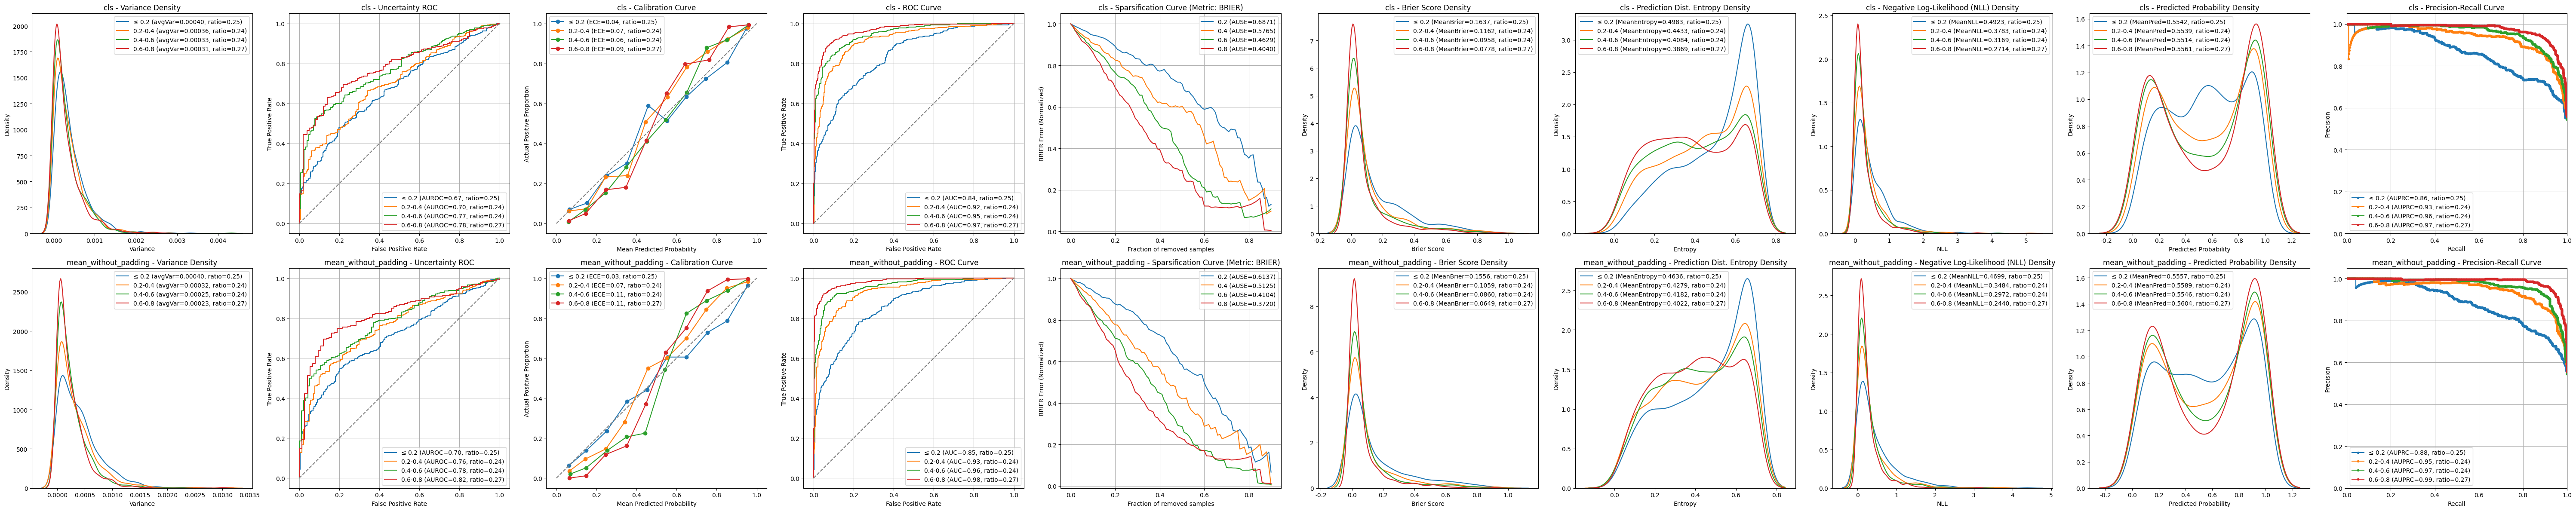

In [11]:
y_val_int = np.array(y_val_aug)
truncations = [0.2,0.4,0.6,0.8]
truncation_colors= sns.color_palette("tab10", n_colors=len(truncations))
data=model_result_show(
    res_set,
    y_val_int,
    np.array(val_trunc_levels),
    poolings,
    truncations,
    truncation_colors,
    metric='brier'
)


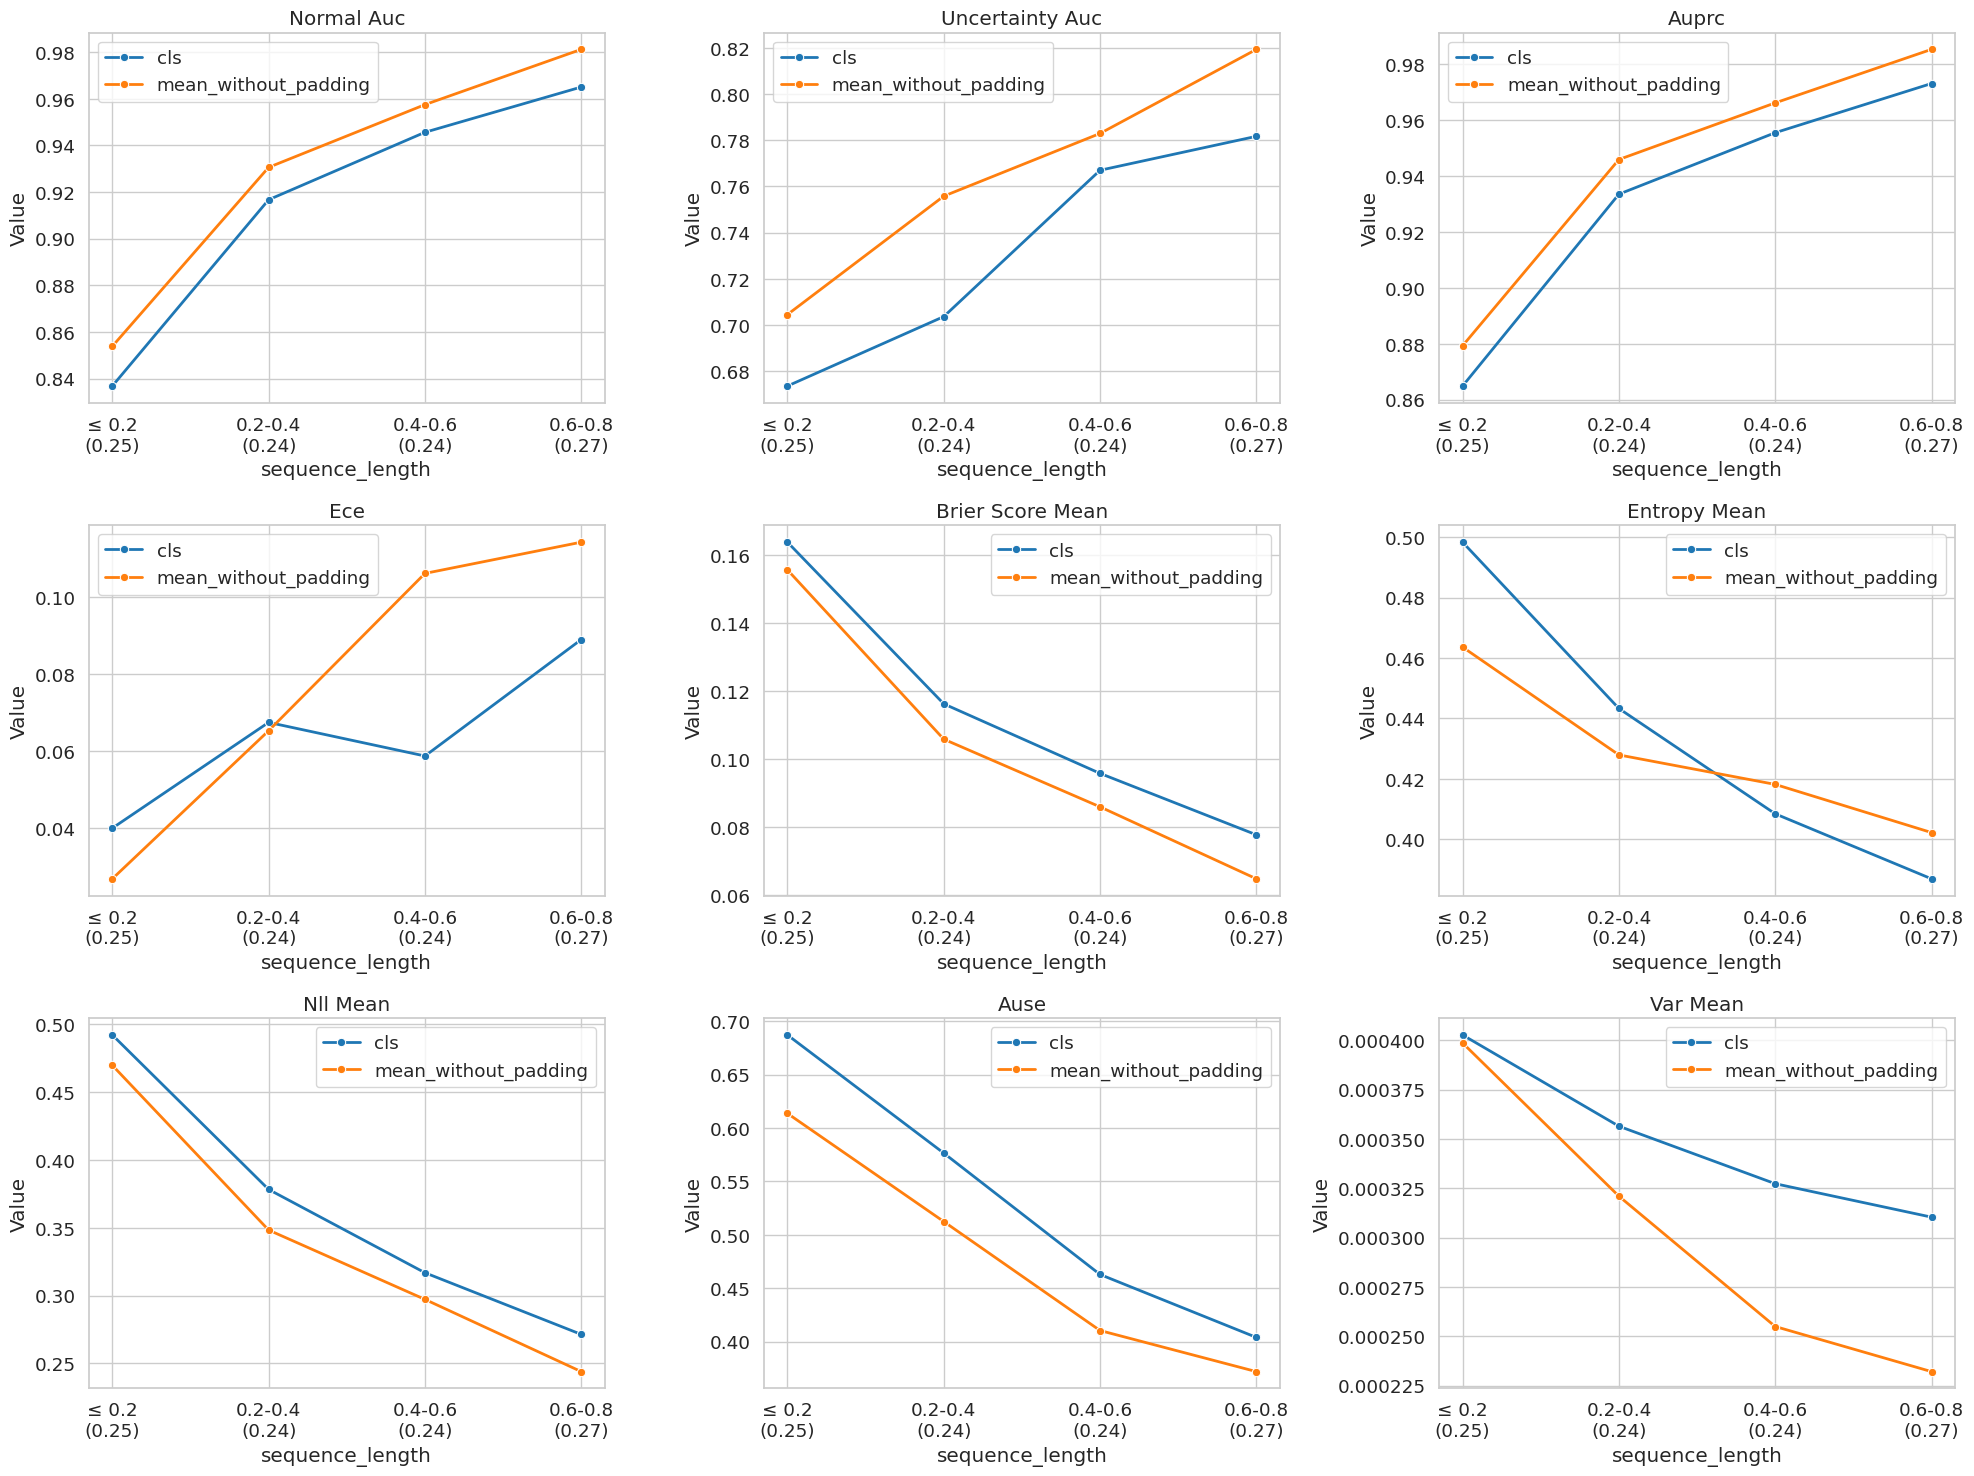

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(data)
truncation_ratio_dict = df.groupby('truncation')['ratio'].first().to_dict()
metrics = df.columns.to_list()[3:10] + df.columns.to_list()[11:]
df_melted = df.melt(
    id_vars=['pooling', 'truncation'],
    value_vars=metrics,
    var_name='metric',
    value_name='value'
)
sns.set(style="whitegrid", font_scale=1.2)
unique_metrics = df_melted['metric'].unique()
unique_poolings = df_melted['pooling'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_poolings))
color_dict = dict(zip(unique_poolings, palette))
num_metrics = len(unique_metrics)
num_cols = 3
num_rows = int(np.ceil(num_metrics / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()
for idx, metric in enumerate(unique_metrics):
    ax = axes[idx]
    data_metric = df_melted[df_melted['metric'] == metric]
    for pooling in unique_poolings:
        data_pooling = data_metric[data_metric['pooling'] == pooling]
        sns.lineplot(
            data=data_pooling,
            x='truncation',
            y='value',
            marker='o',
            label=pooling,
            color=color_dict[pooling],
            ax=ax,
            linewidth=2
        )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('sequence_length')
    ax.set_ylabel('Value')
    ax.legend()
    current_ticklabels = ax.get_xticklabels()
    new_labels = []
    for lbl in current_ticklabels:
        text = lbl.get_text()
        if text in truncation_ratio_dict:
            ratio_val = truncation_ratio_dict[text]
            new_label = f"{text}\n({ratio_val:.2f})"
        else:
            new_label = text
        new_labels.append(new_label)
    ax.set_xticklabels(new_labels)
for j in range(len(unique_metrics), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()


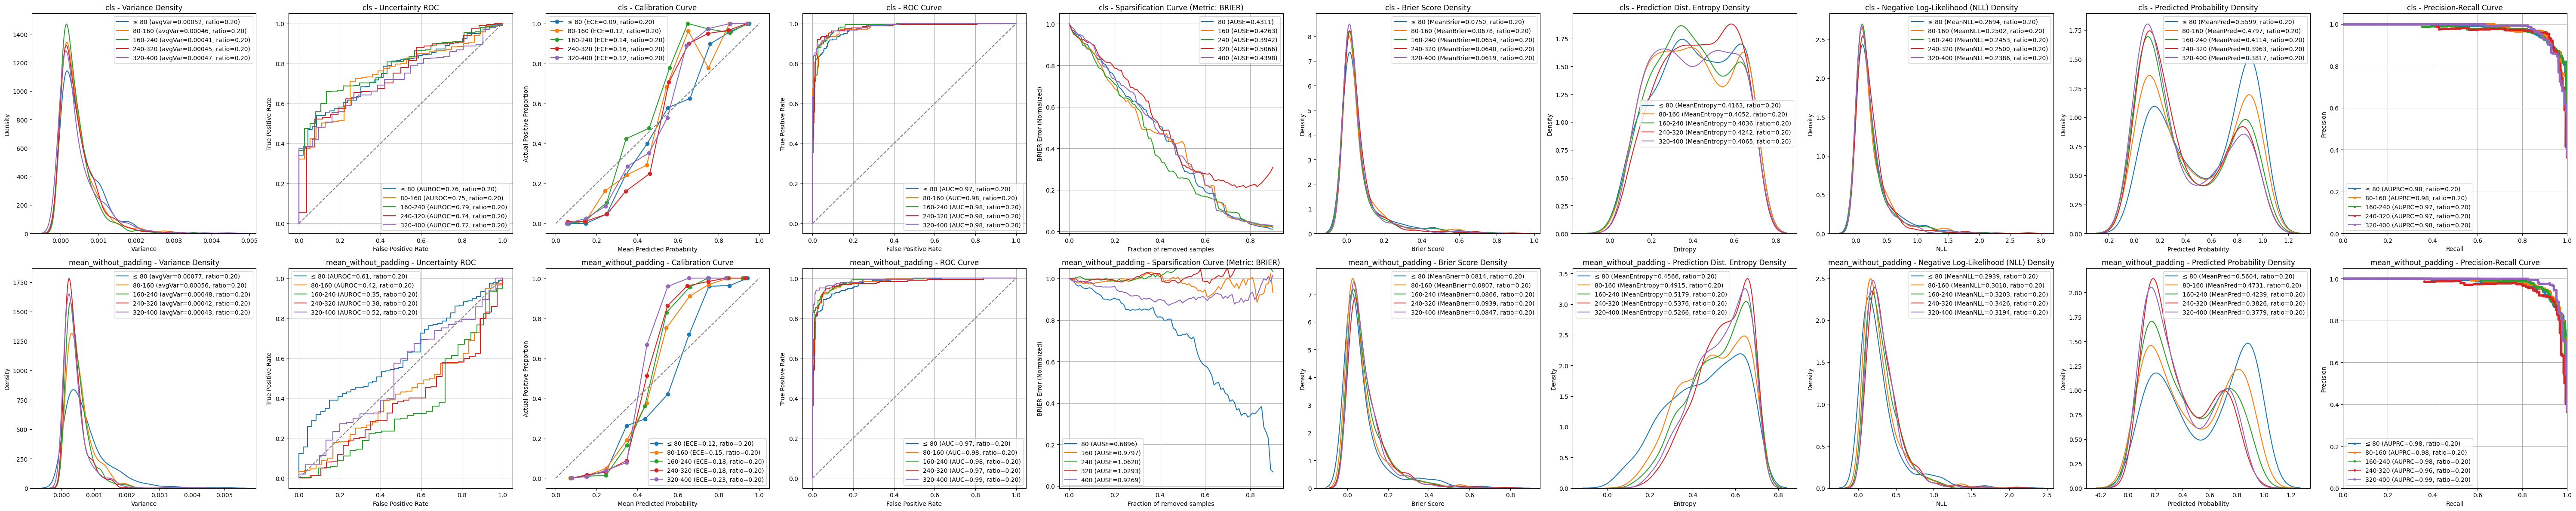

In [41]:
y_val_int = np.array(y_val_aug)
truncations = [0.2,0.4,0.6,0.8]
truncation_colors= sns.color_palette("tab10", n_colors=len(truncations))
data=model_result_show(
    res_set,
    y_val_int,
    np.array(val_trunc_levels),
    poolings,
    truncations,
    truncation_colors,
    metric='brier'
)


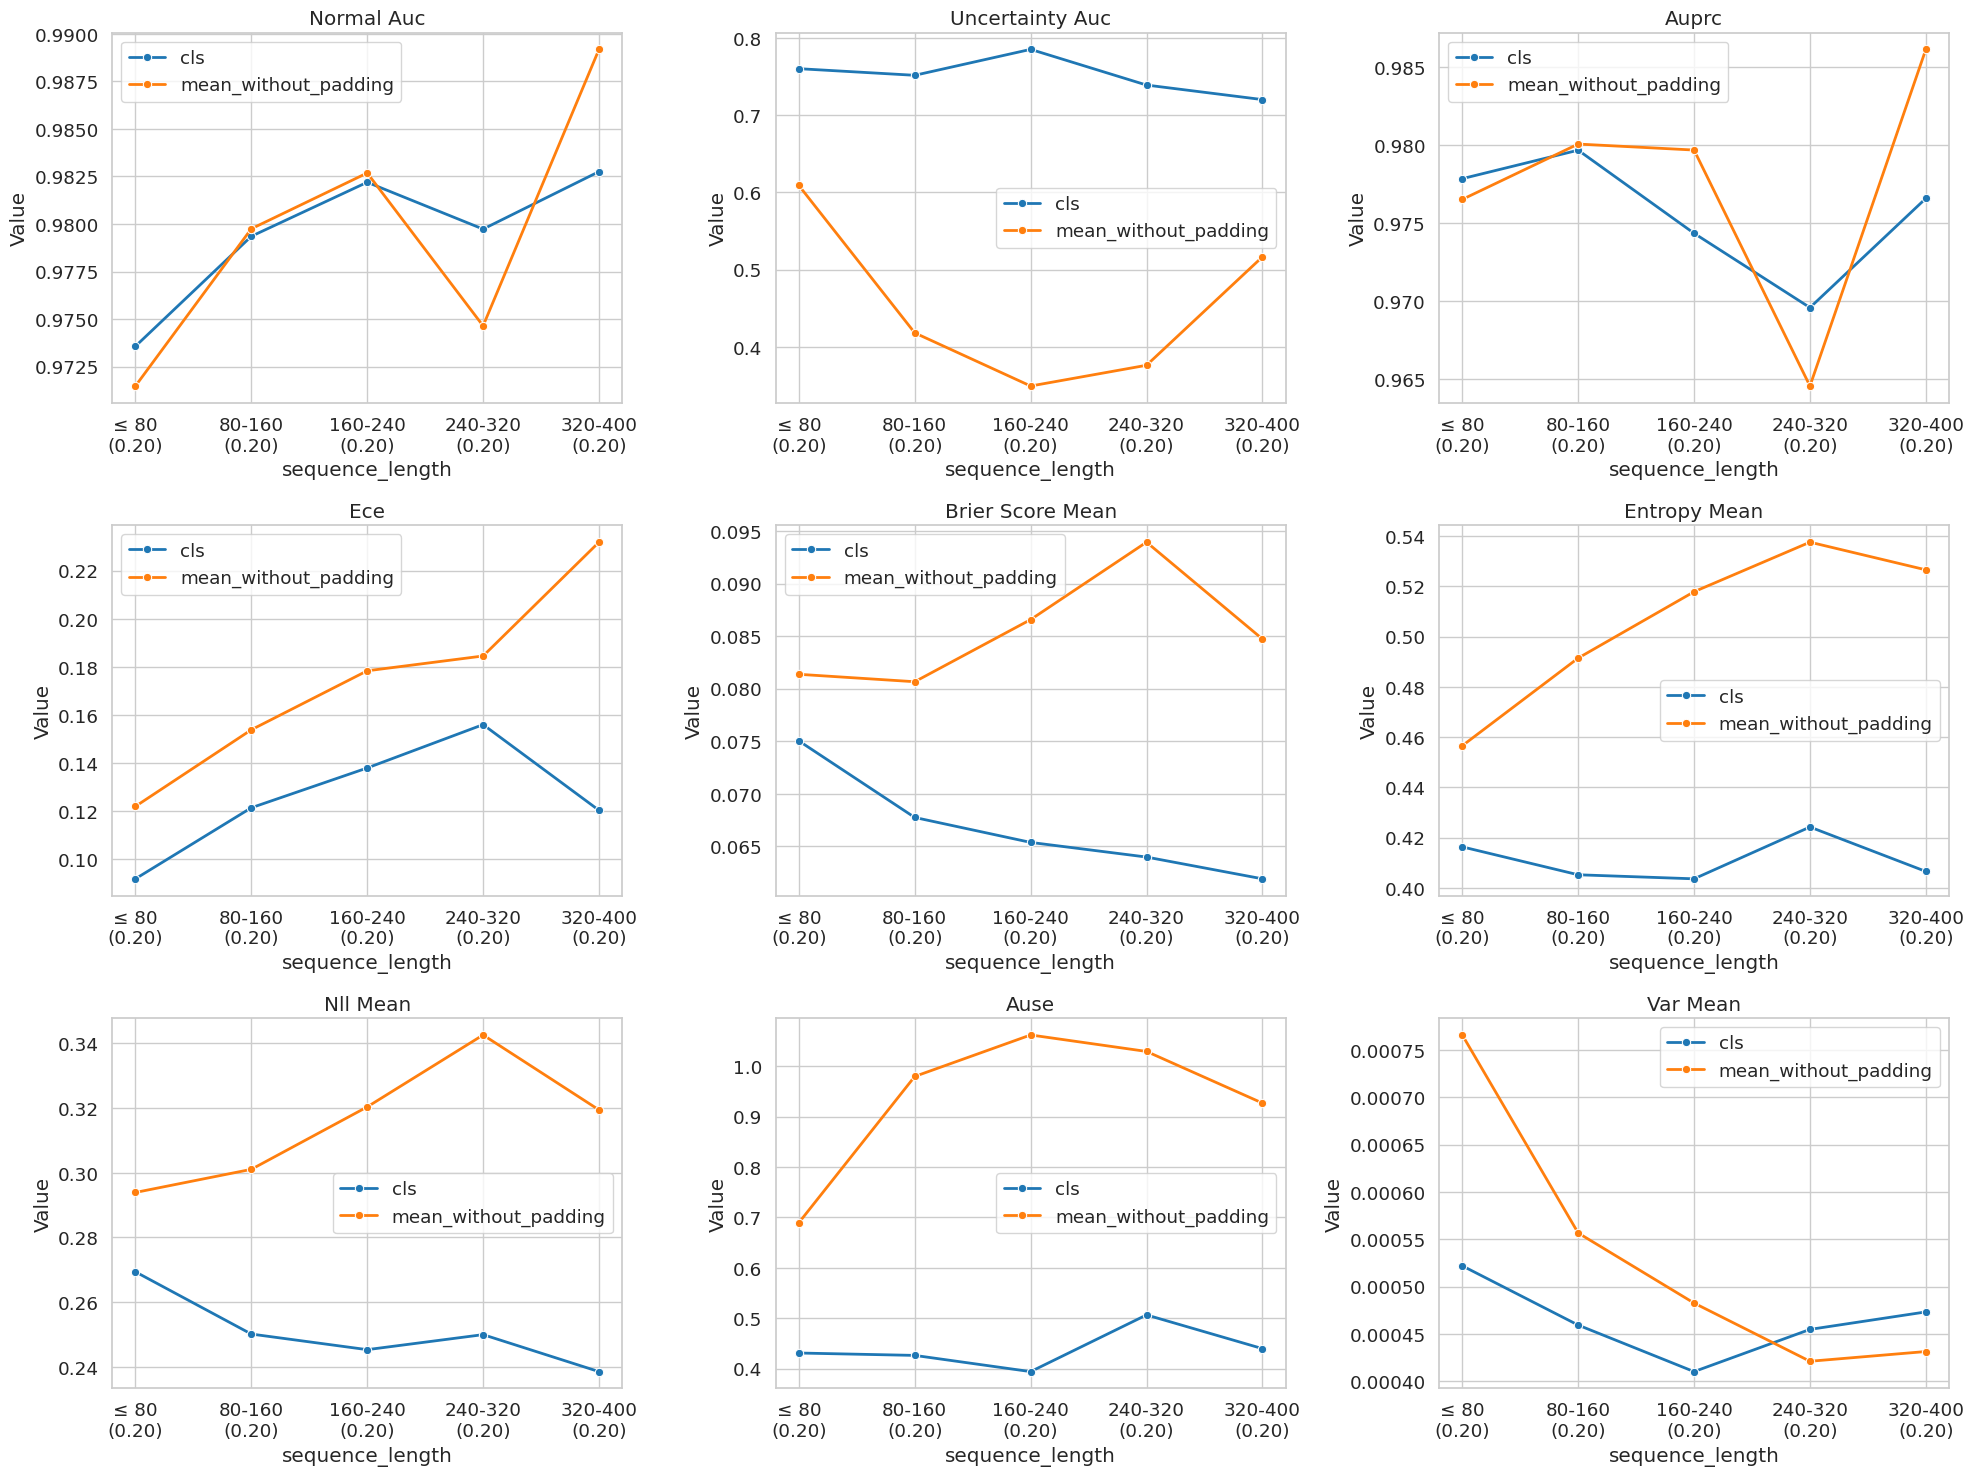

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(data)
truncation_ratio_dict = df.groupby('truncation')['ratio'].first().to_dict()
metrics = df.columns.to_list()[3:10] + df.columns.to_list()[11:]
df_melted = df.melt(
    id_vars=['pooling', 'truncation'],
    value_vars=metrics,
    var_name='metric',
    value_name='value'
)
sns.set(style="whitegrid", font_scale=1.2)
unique_metrics = df_melted['metric'].unique()
unique_poolings = df_melted['pooling'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_poolings))
color_dict = dict(zip(unique_poolings, palette))
num_metrics = len(unique_metrics)
num_cols = 3
num_rows = int(np.ceil(num_metrics / num_cols))
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
axes = axes.flatten()
for idx, metric in enumerate(unique_metrics):
    ax = axes[idx]
    data_metric = df_melted[df_melted['metric'] == metric]
    for pooling in unique_poolings:
        data_pooling = data_metric[data_metric['pooling'] == pooling]
        sns.lineplot(
            data=data_pooling,
            x='truncation',
            y='value',
            marker='o',
            label=pooling,
            color=color_dict[pooling],
            ax=ax,
            linewidth=2
        )
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('sequence_length')
    ax.set_ylabel('Value')
    ax.legend()
    current_ticklabels = ax.get_xticklabels()
    new_labels = []
    for lbl in current_ticklabels:
        text = lbl.get_text()
        if text in truncation_ratio_dict:
            ratio_val = truncation_ratio_dict[text]
            new_label = f"{text}\n({ratio_val:.2f})"
        else:
            new_label = text
        new_labels.append(new_label)
    ax.set_xticklabels(new_labels)
for j in range(len(unique_metrics), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()
